In [7]:
#Loading the Dataset
import pandas as pd
from sqlalchemy import create_engine

# Create the SQLAlchemy engine
engine = create_engine(
    'mssql+pyodbc://DELL7490\\MSSQLSERVER01/RealEstateData?driver=ODBC+Driver+17+for+SQL+Server&trusted_connection=yes'
)

# Query the data from SQL Server
query = "SELECT * FROM [dbo].[Real estate valuation data set]"
df = pd.read_sql(query, engine)

# Display the first few rows to confirm loading
print(df.head())


   No  X1_transaction_date  X2_house_age  \
0   1          2012.916992          32.0   
1   2          2012.916992          19.5   
2   3          2013.583008          13.3   
3   4          2013.500000          13.3   
4   5          2012.833008           5.0   

   X3_distance_to_the_nearest_MRT_station  X4_number_of_convenience_stores  \
0                               84.878822                               10   
1                              306.594696                                9   
2                              561.984497                                5   
3                              561.984497                                5   
4                              390.568390                                5   

   X5_latitude  X6_longitude  Y_house_price_of_unit_area  
0    24.982981    121.540237                   37.900002  
1    24.980339    121.539513                   42.200001  
2    24.987459    121.543907                   47.299999  
3    24.987459    121.543907  

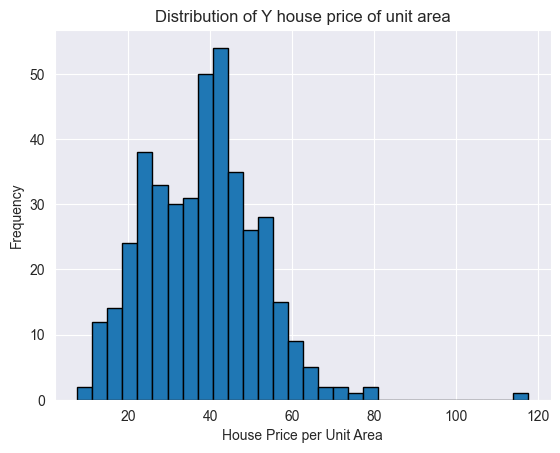

In [2]:
#Plotting Histogram of Target Variable
#code generates a histogram to visualize the distribution of house prices,helps you understand how house prices are distributed across different ranges, which is important for categorizing them into classes.
import matplotlib.pyplot as plt

# Plot histogram for 'Y house price of unit area'
df['Y house price of unit area'].plot.hist(bins=30, edgecolor='black')
plt.title('Distribution of Y house price of unit area')
plt.xlabel('House Price per Unit Area')
plt.ylabel('Frequency')
plt.show()

In [3]:
#Categorizing Target Variable into Three Classes
# Categorize 'Y house price of unit area' into 3 classes using quantiles
#pd.qcut() divides the continuous target variable ('Y house price of unit area') into three equal-sized categories (low(0), medium(1), high(2)) based on quantiles.
df['price_category'] = pd.qcut(df['Y house price of unit area'], q=3, labels=[0, 1, 2])

# Verify that the categorization is balanced
# value_counts() checks that each class has roughly the same number of data points.
print(df['price_category'].value_counts())

price_category
0    141
2    137
1    136
Name: count, dtype: int64


In [4]:
#Splitting Data into Training and Test Sets
from sklearn.model_selection import train_test_split

# Features (X) and target (y)
X = df.drop(columns=['Y house price of unit area', 'price_category'])
y = df['price_category']

# Split data into training(80%) and test(20%) sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print("Training set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])

Training set size: 331
Test set size: 83


In [9]:
#Training Logistic Regression Model
#Logistic Regression requires scaled features to perform optimally. Hence,use StandardScaler() to standardize features by removing the mean and scaling to unit variance.
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize Logistic Regression model with increased max_iter
log_reg = LogisticRegression(solver='lbfgs', max_iter=1000) 

# Train the model
log_reg.fit(X_train_scaled, y_train)

# Predictions for Logistic Regression
y_pred_log_reg = log_reg.predict(X_test_scaled)

In [10]:
#Training Decision Tree Model
#Unlike Logistic Regression, Decision Trees do not require feature scaling,DecisionTreeClassifier() initializes a Decision Tree model.
from sklearn.tree import DecisionTreeClassifier

# Initialize Decision Tree classifier
decision_tree = DecisionTreeClassifier()

# Train the model
decision_tree.fit(X_train, y_train)

# Predictions for Decision Tree
y_pred_decision_tree = decision_tree.predict(X_test)

In [11]:
# Evaluating Models Using Classification Report
from sklearn.metrics import classification_report

# Evaluation for Logistic Regression
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_log_reg))

# Evaluation for Decision Tree Classifier
print("Decision Tree Classification Report:")
print(classification_report(y_test, y_pred_decision_tree))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.86      0.87        28
           1       0.71      0.74      0.73        27
           2       0.79      0.79      0.79        28

    accuracy                           0.80        83
   macro avg       0.80      0.79      0.80        83
weighted avg       0.80      0.80      0.80        83

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.86      0.84        28
           1       0.67      0.59      0.63        27
           2       0.73      0.79      0.76        28

    accuracy                           0.75        83
   macro avg       0.74      0.75      0.74        83
weighted avg       0.74      0.75      0.74        83



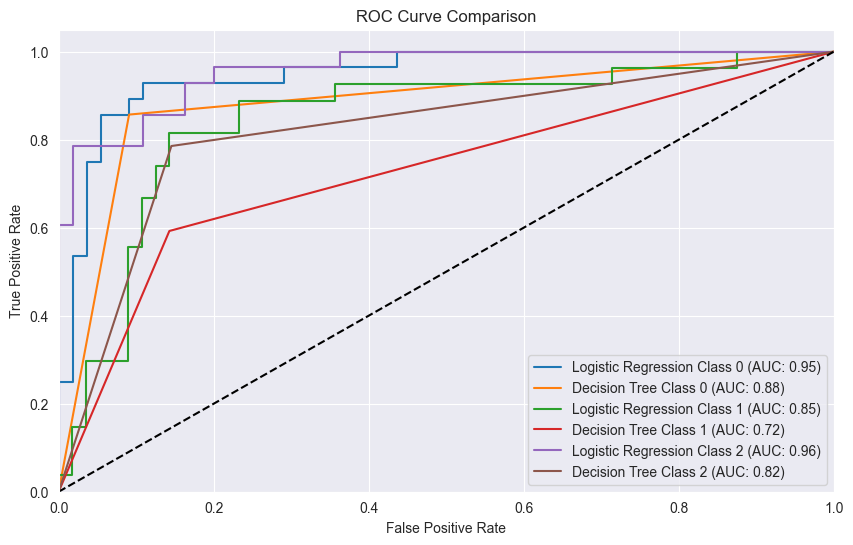

In [14]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the output labels for ROC curve plotting
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# Get predicted probabilities for both models
y_score_log_reg = log_reg.predict_proba(X_test_scaled)
y_score_decision_tree = decision_tree.predict_proba(X_test)

# Plot ROC curves for each class (One-vs-Rest)
fpr_log_reg = dict()
tpr_log_reg = dict()
roc_auc_log_reg = dict()
fpr_decision_tree = dict()
tpr_decision_tree = dict()
roc_auc_decision_tree = dict()

for i in range(n_classes):
    fpr_log_reg[i], tpr_log_reg[i], _ = roc_curve(y_test_bin[:, i], y_score_log_reg[:, i])
    roc_auc_log_reg[i] = auc(fpr_log_reg[i], tpr_log_reg[i])

    fpr_decision_tree[i], tpr_decision_tree[i], _ = roc_curve(y_test_bin[:, i], y_score_decision_tree[:, i])
    roc_auc_decision_tree[i] = auc(fpr_decision_tree[i], tpr_decision_tree[i])

import matplotlib.pyplot as plt

# Plot ROC curves for Logistic Regression vs Decision Tree
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr_log_reg[i], tpr_log_reg[i], label=f'Logistic Regression Class {i} (AUC: {roc_auc_log_reg[i]:.2f})')
    plt.plot(fpr_decision_tree[i], tpr_decision_tree[i], label=f'Decision Tree Class {i} (AUC: {roc_auc_decision_tree[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.show()

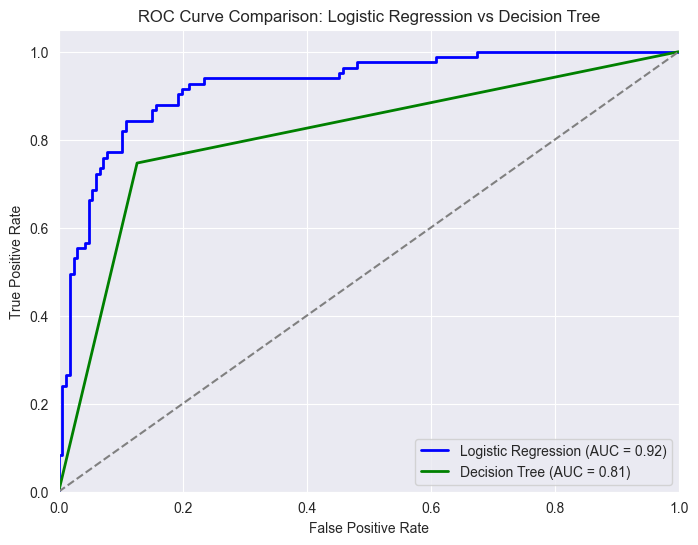

In [18]:
#Creating ROC Curve for Both Models
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# Binarize the output labels for multiclass classification (One-vs-Rest)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# Get predicted probabilities for both models
y_score_log_reg = log_reg.predict_proba(X_test_scaled)
y_score_decision_tree = decision_tree.predict_proba(X_test)

# Compute macro-average ROC curve and AUC for Logistic Regression
fpr_log_reg, tpr_log_reg, _ = roc_curve(y_test_bin.ravel(), y_score_log_reg.ravel())
roc_auc_log_reg = auc(fpr_log_reg, tpr_log_reg)

# Compute macro-average ROC curve and AUC for Decision Tree
fpr_decision_tree, tpr_decision_tree, _ = roc_curve(y_test_bin.ravel(), y_score_decision_tree.ravel())
roc_auc_decision_tree = auc(fpr_decision_tree, tpr_decision_tree)

# Plotting the ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_log_reg, tpr_log_reg, color='blue', lw=2, label=f'Logistic Regression (AUC = {roc_auc_log_reg:.2f})')
plt.plot(fpr_decision_tree, tpr_decision_tree, color='green', lw=2, label=f'Decision Tree (AUC = {roc_auc_decision_tree:.2f})')

# Plot diagonal line representing random classifier
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Labels and title
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison: Logistic Regression vs Decision Tree')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#ROC Curve Summary:
# 
# 1. Logistic Regression:
#    - AUC: 0.92
#    - Interpretation: Logistic Regression performs very well in distinguishing between classes, with an AUC close to 1, indicating strong predictive power.
# 
# 2. Decision Tree:
#    - AUC: 0.81
#    - Interpretation: Decision Tree also performs reasonably well but not as effectively as Logistic Regression, with an AUC of 0.81 indicating moderate predictive power.
# 
# Conclusion:
# Logistic Regression outperforms Decision Tree in this multiclass classification task, as indicated by its higher AUC score (0.92 vs 0.81). This suggests that Logistic Regression is better suited for this dataset when trying to classify house prices into three categories (low, medium, high) and does less errors.
